Loading data...
Loaded 2263 rows of data
Data date range: 2010-01-04 00:00:00 to 2018-12-28 00:00:00
Adding technical indicators...
Creating target variable for ML model...
Splitting data into train/test...
Using 2016-04-20 00:00:00 as the split date (70/30 split)
Training data: 1584 rows, Test data: 679 rows
Preparing features for ML model...
Training features shape: (1584, 21)
Testing features shape: (674, 21)
Training ensemble models...
Training Model 1 (Balanced)...
Training Model 2 (Conservative)...
Training Model 3 (Aggressive)...
Saving trained models...
Model 1 (balanced) saved successfully as models/model_1_balanced.pkl
Model 2 (conservative) saved successfully as models/model_2_conservative.pkl
Model 3 (aggressive) saved successfully as models/model_3_aggressive.pkl
Complete model ensemble saved successfully
Evaluating ensemble model performance...
Model 1 Performance:
  Accuracy: 0.5267
  Precision: 0.3885
  Recall: 0.2148
  F1 Score: 0.2766
Model 2 Performance:
  Accuracy: 

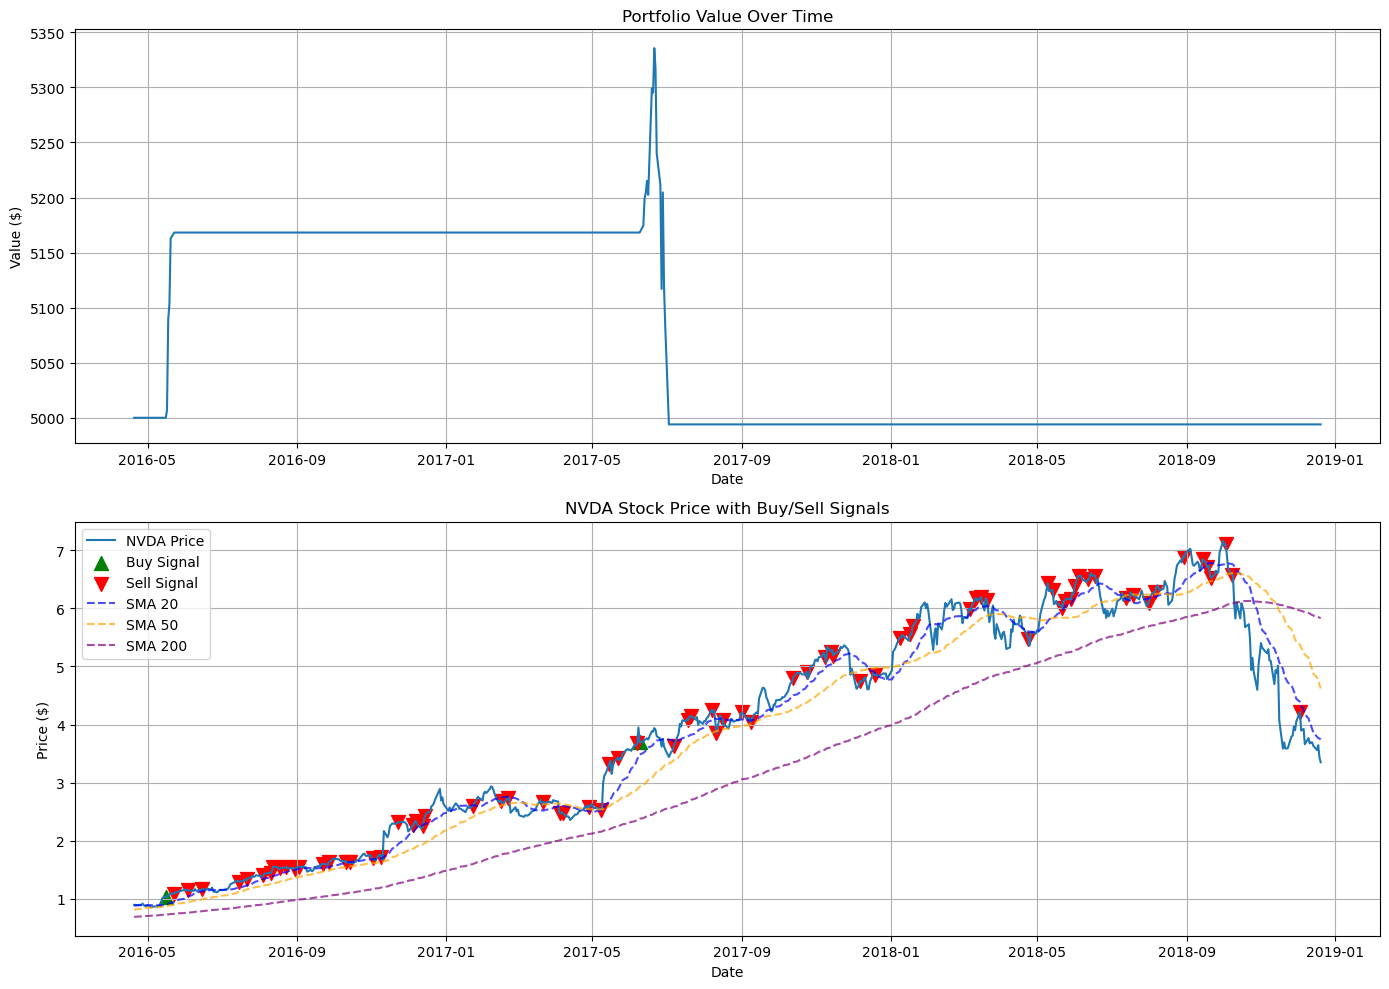

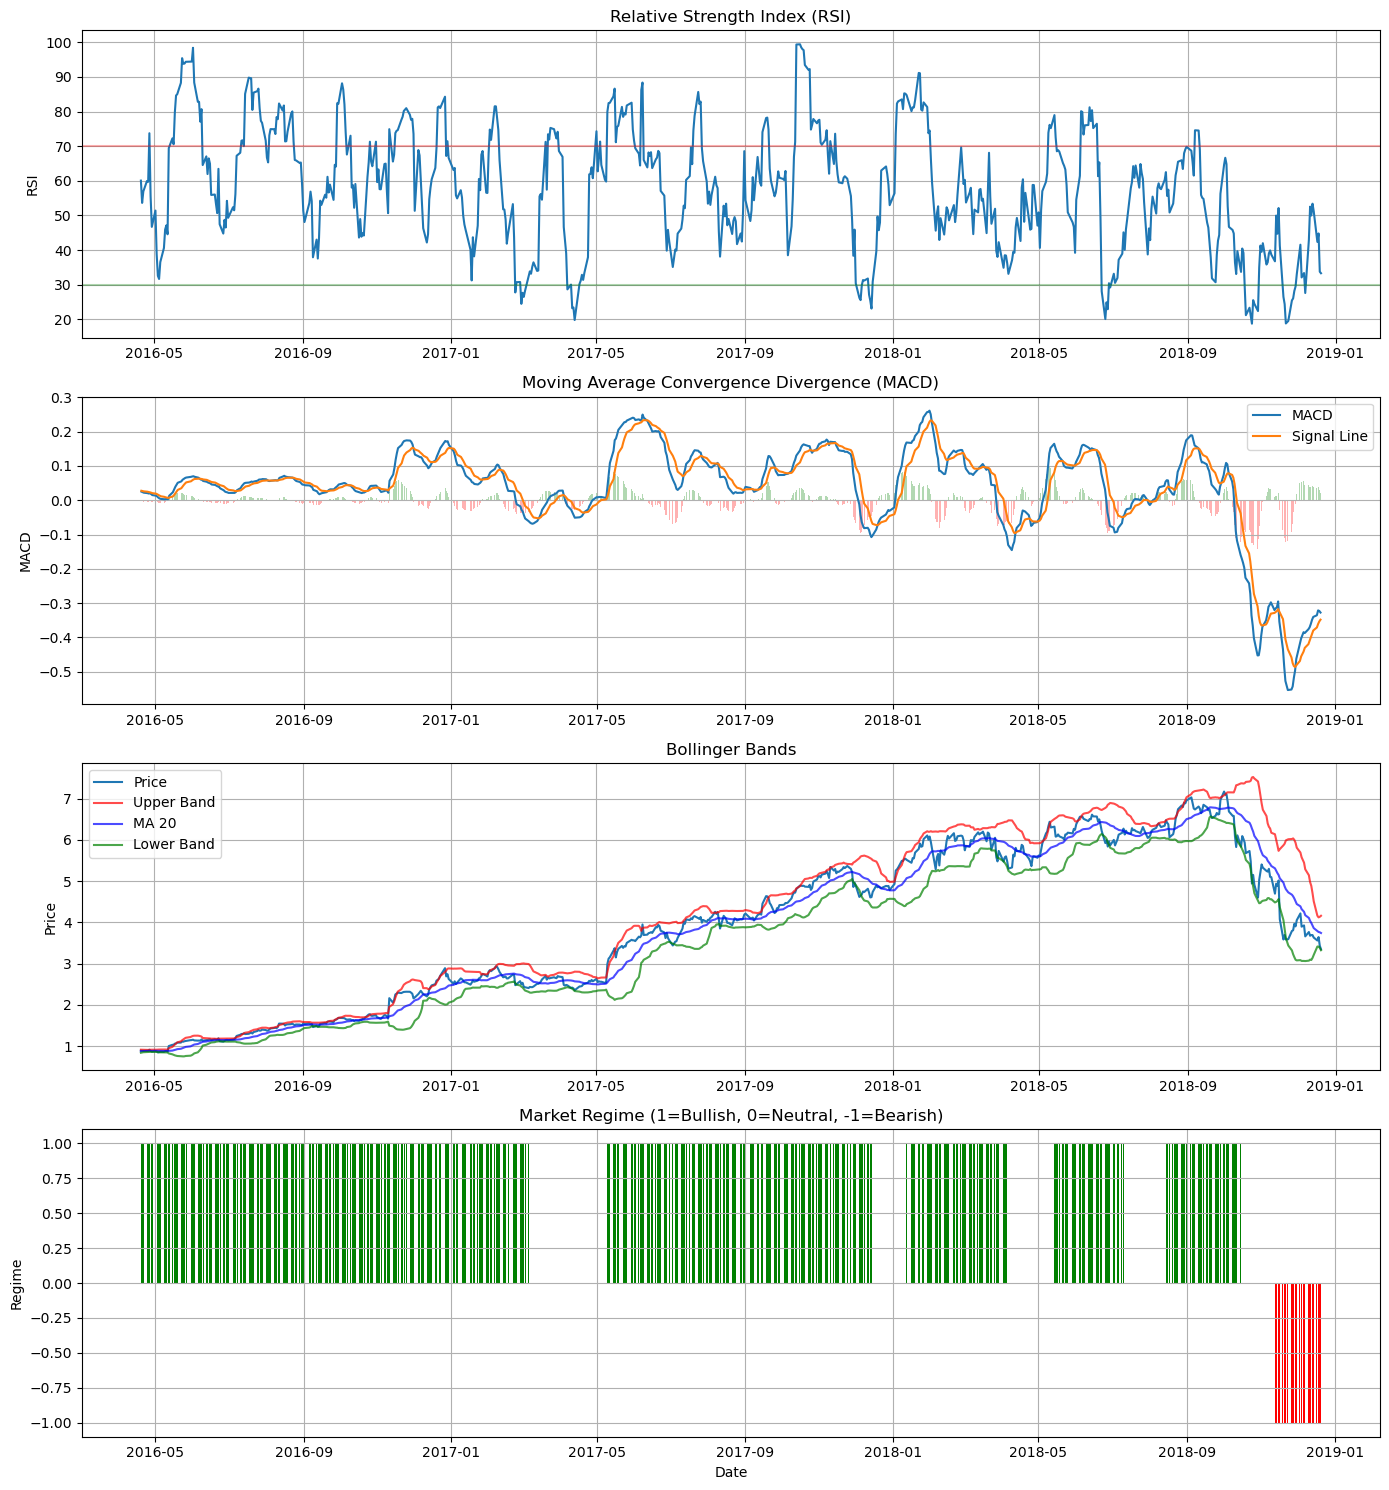

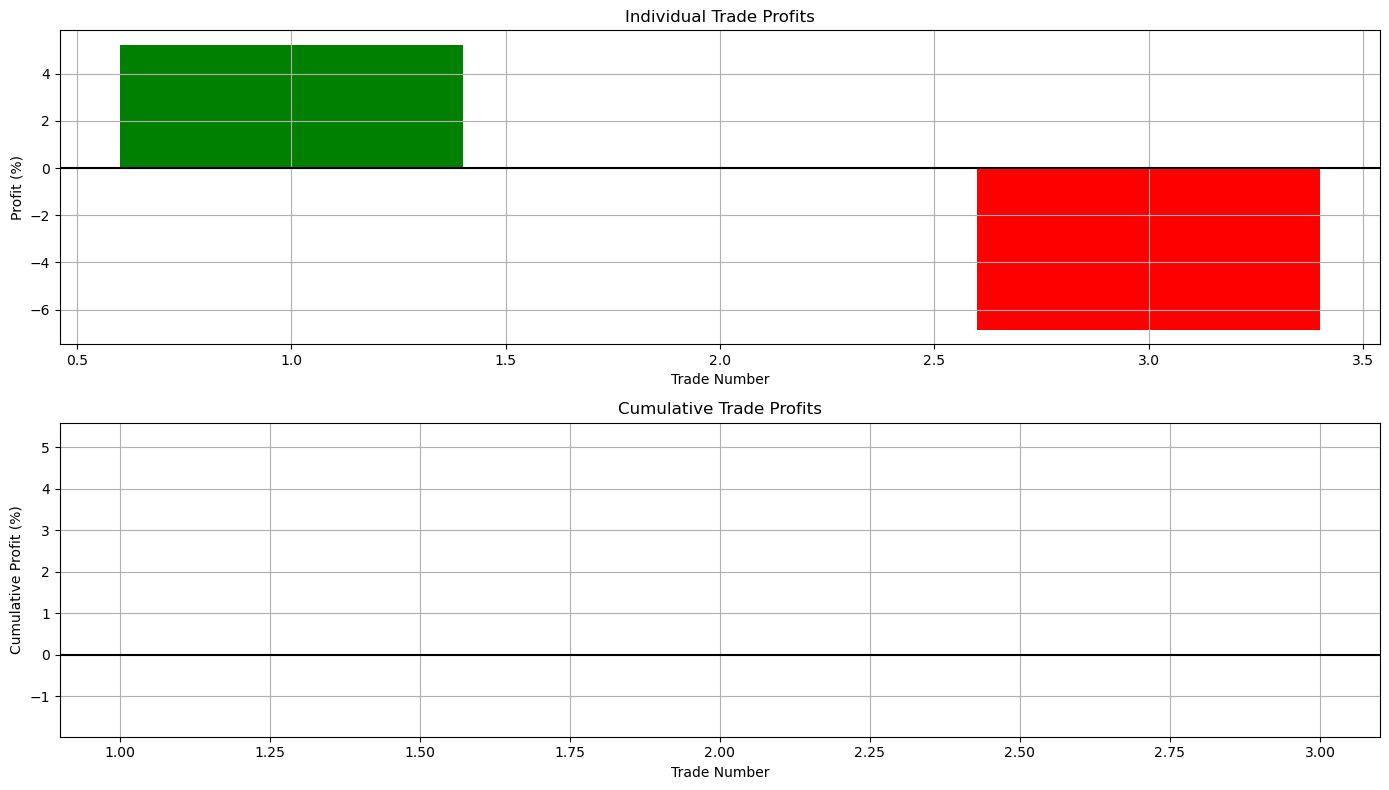

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
def load_data():
    """
    Load the stock data from Excel file
    """
    df = pd.read_excel("NVDA_train.xlsx")
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Add technical indicators
def add_indicators(df):
    """
    Add technical indicators for trading strategy
    """
    # Moving Averages
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    
    # MACD
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['Signal_Line']
    
    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    # Avoid division by zero
    rs = gain / loss.replace(0, np.nan).fillna(loss.mean())
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['std_dev'] = df['Close'].rolling(window=20).std()
    df['Upper_Band'] = df['MA_20'] + (df['std_dev'] * 2)
    df['Lower_Band'] = df['MA_20'] - (df['std_dev'] * 2)
    df['BB_Width'] = (df['Upper_Band'] - df['Lower_Band']) / df['MA_20']
    df['BB_Position'] = (df['Close'] - df['Lower_Band']) / (df['Upper_Band'] - df['Lower_Band'])
    
    # Average True Range (ATR)
    df['TR'] = np.maximum(
        df['High'] - df['Low'],
        np.maximum(
            abs(df['High'] - df['Close'].shift(1)),
            abs(df['Low'] - df['Close'].shift(1))
        )
    )
    df['ATR'] = df['TR'].rolling(window=14).mean()
    df['ATR_Pct'] = df['ATR'] / df['Close']  # ATR as percentage of price
    
    # Volume-based indicators
    df['Volume_Change'] = df['Volume'].pct_change()
    df['Volume_MA_20'] = df['Volume'].rolling(window=20).mean()
    df['Relative_Volume'] = df['Volume'] / df['Volume_MA_20']
    
    # Price momentum
    df['Momentum_5'] = df['Close'] / df['Close'].shift(5) - 1
    df['Momentum_10'] = df['Close'] / df['Close'].shift(10) - 1
    df['Momentum_20'] = df['Close'] / df['Close'].shift(20) - 1
    
    # Mean reversion
    df['Dist_MA_20'] = (df['Close'] - df['MA_20']) / df['MA_20']
    df['Dist_MA_50'] = (df['Close'] - df['SMA_50']) / df['SMA_50']
    
    # Market Regime Detection
    df['Regime'] = 0  # Neutral by default
    # Bullish regime: Short-term MA > Medium-term MA > Long-term MA
    bullish = (df['SMA_20'] > df['SMA_50']) & (df['SMA_50'] > df['SMA_200'])
    df.loc[bullish, 'Regime'] = 1
    # Bearish regime: Short-term MA < Medium-term MA < Long-term MA
    bearish = (df['SMA_20'] < df['SMA_50']) & (df['SMA_50'] < df['SMA_200'])
    df.loc[bearish, 'Regime'] = -1
    
    # Fill NaN values that occur at the beginning of series
    df = df.fillna(method='bfill')
    
    return df

# Create target variable for machine learning model
def create_target_variable(df, forward_period=5, threshold=0.02):
    """
    Create target variable for machine learning model
    1 if price increases by at least threshold% in the next forward_period days, 0 otherwise
    """
    # Calculate future price changes
    df['Future_Return'] = df['Close'].shift(-forward_period) / df['Close'] - 1
    
    # Create target variable (1 if price increases by at least threshold% in next forward_period days)
    df['Target'] = 0
    df.loc[df['Future_Return'] > threshold, 'Target'] = 1
    
    return df

# Feature selection and preparation for ML model
def prepare_features(df):
    """
    Prepare features for the machine learning model
    """
    # List of features to include in the model
    feature_columns = [
        'SMA_20', 'SMA_50', 'SMA_200',
        'MACD', 'Signal_Line', 'MACD_Hist',
        'RSI', 'MA_20', 'std_dev', 'BB_Width', 'BB_Position',
        'ATR', 'ATR_Pct', 'Volume_Change', 'Relative_Volume',
        'Momentum_5', 'Momentum_10', 'Momentum_20',
        'Dist_MA_20', 'Dist_MA_50', 'Regime'
    ]
    
    # Drop rows with NaN values (which occur at the beginning due to rolling calculations)
    df_clean = df.dropna().copy()
    
    # Extract features (X) and target (y)
    X = df_clean[feature_columns]
    y = df_clean['Target']
    
    return df_clean, X, y

# Train an ensemble of XGBoost models
def train_ensemble(X_train, y_train):
    """
    Train multiple XGBoost models with different parameters and create an ensemble
    """
    # Model 1: Balanced approach
    model1 = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        random_state=42
    )
    
    # Model 2: More conservative (deeper trees, slower learning)
    model2 = xgb.XGBClassifier(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.7,
        objective='binary:logistic',
        random_state=43
    )
    
    # Model 3: More aggressive (shallower trees, faster learning)
    model3 = xgb.XGBClassifier(
        n_estimators=80,
        max_depth=3,
        learning_rate=0.15,
        subsample=0.9,
        colsample_bytree=0.9,
        objective='binary:logistic',
        random_state=44
    )
    
    # Train all models
    print("Training Model 1 (Balanced)...")
    model1.fit(X_train, y_train)
    
    print("Training Model 2 (Conservative)...")
    model2.fit(X_train, y_train)
    
    print("Training Model 3 (Aggressive)...")
    model3.fit(X_train, y_train)
    save_models([model1, model2, model3])
    # Return the ensemble
    return [model1, model2, model3]

# Evaluate the ensemble
def evaluate_ensemble(models, X_test, y_test):
    """
    Evaluate the ensemble model performance
    """
    # Make predictions from each model
    probas = []
    for i, model in enumerate(models):
        # Get probabilities of positive class
        proba = model.predict_proba(X_test)[:, 1]
        probas.append(proba)
        
        # Calculate metrics for individual model
        y_pred = (proba >= 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        
        print(f"Model {i+1} Performance:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
    
    # Calculate ensemble probabilities (average of all models)
    ensemble_probas = np.mean(probas, axis=0)
    
    # Make ensemble predictions
    ensemble_preds = (ensemble_probas >= 0.5).astype(int)
    
    # Calculate ensemble metrics
    accuracy = accuracy_score(y_test, ensemble_preds)
    precision = precision_score(y_test, ensemble_preds, zero_division=0)
    recall = recall_score(y_test, ensemble_preds, zero_division=0)
    f1 = f1_score(y_test, ensemble_preds, zero_division=0)
    conf_matrix = confusion_matrix(y_test, ensemble_preds)
    
    # Print ensemble evaluation metrics
    print("\nEnsemble Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Calculate feature importance (use the first model as representative)
    importance = models[0].feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)
    
    print("\nTop 10 Feature Importance:")
    print(feature_importance.head(10))
    
    return {
        'ensemble_probas': ensemble_probas,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix,
        'feature_importance': feature_importance
    }

# Generate trading signals with more refined entry criteria
def generate_trading_signals(df_clean, ensemble_probas):
    """
    Generate trading signals based on ensemble predictions with more refined entry criteria
    """
    # Add probabilities to the dataframe
    df_clean['Ensemble_Probability'] = ensemble_probas
    
    # Initialize signal columns
    df_clean['Buy'] = 0
    df_clean['Sell'] = 0
    
    # Market regime adaptation
    for i in range(1, len(df_clean)):
        regime = df_clean['Regime'].iloc[i]
        
        # Set different thresholds based on market regime
        if regime == 1:  # Bullish regime
            buy_threshold = 0.55  # Lower buy threshold in bullish market
            sell_threshold = 0.3   # Lower sell threshold
        elif regime == -1:  # Bearish regime
            buy_threshold = 0.8   # Higher buy threshold in bearish market
            sell_threshold = 0.4   # Higher sell threshold
        else:  # Neutral regime
            buy_threshold = 0.65  # Default
            sell_threshold = 0.35  # Default
        
        prev_prob = df_clean['Ensemble_Probability'].iloc[i-1]
        curr_prob = df_clean['Ensemble_Probability'].iloc[i]
        
        # Buy signal: probability crosses above threshold
        if prev_prob < buy_threshold and curr_prob >= buy_threshold:
            df_clean.loc[df_clean.index[i], 'Buy'] = 1
        
        # Sell signal: probability crosses below threshold
        elif prev_prob > sell_threshold and curr_prob <= sell_threshold:
            df_clean.loc[df_clean.index[i], 'Sell'] = 1
    
    # IMPROVEMENT: Trend filtering - Only take buy signals in strong uptrends
    strong_uptrend = (df_clean['SMA_20'] > df_clean['SMA_50']) & (df_clean['SMA_50'] > df_clean['SMA_200'])
    df_clean.loc[~strong_uptrend, 'Buy'] = 0  # No buying except in strong uptrends
    
    # IMPROVEMENT: More selective buying criteria
    price_momentum = df_clean['Momentum_5'] > 0  # Positive short-term momentum
    volume_confirmation = df_clean['Relative_Volume'] > 1.2  # Above average volume
    bollinger_position = df_clean['BB_Position'] < 0.3  # Not overbought in Bollinger terms
    
    # Require at least 2 of these 3 additional confirmations
    confirmation_count = price_momentum.astype(int) + volume_confirmation.astype(int) + bollinger_position.astype(int)
    df_clean.loc[(df_clean['Buy'] == 1) & (confirmation_count < 2), 'Buy'] = 0
    
    # Signal confirmation with technical indicators
    rsi_oversold = df_clean['RSI'] < 35  # Slightly relaxed from 30
    macd_positive = df_clean['MACD'] > df_clean['Signal_Line']
    price_above_sma = df_clean['Close'] > df_clean['SMA_50']
    
    # Only keep buy signals that have at least 2 of the 3 confirmation indicators
    tech_confirmation_count = rsi_oversold.astype(int) + macd_positive.astype(int) + price_above_sma.astype(int)
    df_clean.loc[(df_clean['Buy'] == 1) & (tech_confirmation_count < 2), 'Buy'] = 0
    
    return df_clean

# Backtest with profit targets and improved risk management
def backtest_strategy(df, initial_budget=10000, fixed_deposit_pct=0.5, annual_interest_rate=0.04):
    """
    Backtest the trading strategy with improved risk management, profit targets and position sizing
    """
    # Setup initial allocation
    trading_capital = initial_budget * (1 - fixed_deposit_pct)
    fixed_deposit = initial_budget * fixed_deposit_pct
    
    # Calculate fixed deposit growth
    start_date = df['Date'].min()
    end_date = df['Date'].max()
    days_difference = max(1, (end_date - start_date).days)
    years_passed = days_difference / 365.25
    fixed_deposit_end = fixed_deposit * ((1 + annual_interest_rate) ** years_passed)
    
    # Initialize trading variables
    cash = trading_capital
    shares = 0
    trades = []
    portfolio_values = []
    entry_price = 0  # Track entry price for stop loss
    
    # IMPROVEMENT: Enhanced risk management parameters
    max_loss_pct = 0.05  # 5% stop loss
    take_profit_pct = 0.12  # 12% profit target (NEW)
    trailing_stop_pct = 0.08  # Reduced from 10% to 8% (tighter)
    trailing_stop_activation = 0.10  # Reduced from 15% to 10% (activate earlier)
    max_position_pct = 0.90  # Slightly reduced from 95% to 90%
    
    # Track winning and losing trades for proper profit factor calculation
    winning_trade_profits = 0
    losing_trade_losses = 0
    
    # Loop through the data
    for i in range(len(df)):
        current_date = df['Date'].iloc[i]
        price = df['Close'].iloc[i]
        buy_signal = df['Buy'].iloc[i]
        sell_signal = df['Sell'].iloc[i]
        
        # Track portfolio value before any trades
        portfolio_value = cash + (shares * price)
        portfolio_values.append({
            'Date': current_date,
            'Cash': cash,
            'Shares': shares,
            'Portfolio_Value': portfolio_value
        })
        
        # Apply exit strategies if we have shares
        if shares > 0:
            # Calculate current profit percentage
            current_profit_pct = (price / entry_price) - 1
            
            # IMPROVEMENT: Check if profit target is reached
            if price >= entry_price * (1 + take_profit_pct):
                # Take profit triggered
                proceeds = shares * price
                
                trades.append({
                    'Date': current_date,
                    'Action': 'TAKE PROFIT',
                    'Price': price,
                    'Shares': shares,
                    'Value': proceeds,
                    'Cash': cash + proceeds,
                    'Profit_Pct': current_profit_pct * 100
                })
                
                # Update winning trade tracking
                winning_trade_profits += current_profit_pct * proceeds
                
                # Update portfolio
                cash += proceeds
                shares = 0
                continue  # Skip to next iteration
            
            # Check if stop loss is triggered
            if price <= entry_price * (1 - max_loss_pct):
                # Stop loss triggered
                proceeds = shares * price
                
                trades.append({
                    'Date': current_date,
                    'Action': 'STOP LOSS',
                    'Price': price,
                    'Shares': shares,
                    'Value': proceeds,
                    'Cash': cash + proceeds,
                    'Profit_Pct': current_profit_pct * 100
                })
                
                # Update losing trade tracking
                losing_trade_losses += abs(current_profit_pct) * proceeds
                
                # Update portfolio
                cash += proceeds
                shares = 0
                continue  # Skip to next iteration
            
            # IMPROVEMENT: Tighter trailing stop that activates earlier
            if current_profit_pct >= trailing_stop_activation:
                # Calculate trailing stop price
                max_price_seen = max(entry_price * (1 + current_profit_pct), df['High'].iloc[i])
                trailing_stop_price = max_price_seen * (1 - trailing_stop_pct)
                
                if price <= trailing_stop_price:
                    # Trailing stop triggered
                    proceeds = shares * price
                    
                    trades.append({
                        'Date': current_date,
                        'Action': 'TRAILING STOP',
                        'Price': price,
                        'Shares': shares,
                        'Value': proceeds,
                        'Cash': cash + proceeds,
                        'Profit_Pct': current_profit_pct * 100
                    })
                    
                    # Update trade profit tracking based on whether it's a win or loss
                    if current_profit_pct > 0:
                        winning_trade_profits += current_profit_pct * proceeds
                    else:
                        losing_trade_losses += abs(current_profit_pct) * proceeds
                    
                    # Update portfolio
                    cash += proceeds
                    shares = 0
                    continue  # Skip to next iteration
        
        # Handle buy signal
        if buy_signal == 1 and cash > price and shares == 0:
            # Position sizing based on volatility
            volatility = df['ATR_Pct'].iloc[i]
            if np.isnan(volatility) or volatility <= 0:
                volatility = 0.02  # Default if not available
                
            # Adjust position size inversely with volatility (higher volatility = smaller position)
            position_pct = min(max_position_pct, 0.02 / volatility)
            position_value = cash * position_pct
            
            # Calculate how many shares to buy
            shares_to_buy = int(position_value // price)
            
            if shares_to_buy > 0:  # Only buy if we can afford at least one share
                cost = shares_to_buy * price
                
                # Update portfolio
                shares = shares_to_buy
                cash -= cost
                entry_price = price  # Track entry price for stop loss
                
                trades.append({
                    'Date': current_date,
                    'Action': 'BUY',
                    'Price': price,
                    'Shares': shares,
                    'Value': cost,
                    'Cash': cash,
                    'Position_Pct': position_pct * 100
                })
        
        # Handle sell signal
        elif sell_signal == 1 and shares > 0:
            # Calculate profit percentage
            profit_pct = (price / entry_price) - 1
            
            # Sell all shares
            proceeds = shares * price
            
            trades.append({
                'Date': current_date,
                'Action': 'SELL',
                'Price': price,
                'Shares': shares,
                'Value': proceeds,
                'Cash': cash + proceeds,
                'Profit_Pct': profit_pct * 100
            })
            
            # Update trade profit tracking based on whether it's a win or loss
            if profit_pct > 0:
                winning_trade_profits += profit_pct * proceeds
            else:
                losing_trade_losses += abs(profit_pct) * proceeds
            
            # Update portfolio
            cash += proceeds
            shares = 0
    
    # Liquidate any remaining positions at the end
    if shares > 0:
        final_price = df['Close'].iloc[-1]
        proceeds = shares * final_price
        profit_pct = (final_price / entry_price) - 1
        
        trades.append({
            'Date': df['Date'].iloc[-1],
            'Action': 'FINAL SELL',
            'Price': final_price,
            'Shares': shares,
            'Value': proceeds,
            'Cash': cash + proceeds,
            'Profit_Pct': profit_pct * 100
        })
        
        # Update trade profit tracking based on whether it's a win or loss
        if profit_pct > 0:
            winning_trade_profits += profit_pct * proceeds
        else:
            losing_trade_losses += abs(profit_pct) * proceeds
        
        cash += proceeds
        shares = 0
    
    # Calculate final values
    final_trading_value = cash
    final_total_value = final_trading_value + fixed_deposit_end
    
    # Calculate returns
    total_return = (final_total_value / initial_budget - 1) * 100
    annual_return = ((final_total_value / initial_budget) ** (1 / years_passed) - 1) * 100
    
    # Calculate trade statistics
    if len(trades) > 0:
        trade_df = pd.DataFrame(trades)
        
        # Calculate winning and losing trades
        if 'Profit_Pct' in trade_df.columns:
            winning_trades = trade_df[trade_df['Profit_Pct'] > 0]
            losing_trades = trade_df[trade_df['Profit_Pct'] <= 0]
            
            win_rate = len(winning_trades) / len(trade_df) * 100 if len(trade_df) > 0 else 0
            avg_win = winning_trades['Profit_Pct'].mean() if len(winning_trades) > 0 else 0
            avg_loss = losing_trades['Profit_Pct'].mean() if len(losing_trades) > 0 else 0
            
            # IMPROVEMENT: Fixed profit factor calculation
            profit_factor = winning_trade_profits / losing_trade_losses if losing_trade_losses > 0 else float('inf')
        else:
            win_rate = 0
            avg_win = 0
            avg_loss = 0
            profit_factor = 0
    else:
        win_rate = 0
        avg_win = 0
        avg_loss = 0
        profit_factor = 0
    
    # Create results dictionary
    results = {
        'Initial_Budget': initial_budget,
        'Trading_Capital': trading_capital,
        'Fixed_Deposit': fixed_deposit,
        'Fixed_Deposit_End': fixed_deposit_end,
        'Final_Trading_Value': final_trading_value,
        'Final_Total_Value': final_total_value,
        'Total_Return_Pct': total_return,
        'Annual_Return_Pct': annual_return,
        'Number_of_Trades': len(trades),
        'Win_Rate': win_rate,
        'Avg_Win_Pct': avg_win,
        'Avg_Loss_Pct': avg_loss,
        'Profit_Factor': profit_factor,
        'Trades': trades,
        'Portfolio_Values': portfolio_values
    }
    
    return results

# Plot performance over time
def plot_performance(results, test_data):
    """
    Plot portfolio value over time
    """
    # Extract portfolio values for plotting
    portfolio_values = results['Portfolio_Values']
    dates = [pv['Date'] for pv in portfolio_values]
    portfolio_values = [pv['Portfolio_Value'] for pv in portfolio_values]
    
    # Plot performance
    plt.figure(figsize=(14, 10))
    
    # Plot 1: Portfolio Value
    plt.subplot(2, 1, 1)
    plt.plot(dates, portfolio_values)
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.grid(True)
    
    # Plot 2: Stock Price with Buy/Sell Signals
    plt.subplot(2, 1, 2)
    plt.plot(test_data['Date'], test_data['Close'], label='NVDA Price')
    
    # Plot buy signals
    buy_signals = test_data[test_data['Buy'] == 1]
    if not buy_signals.empty:
        plt.scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', s=100, label='Buy Signal')
    
    # Plot sell signals
    sell_signals = test_data[test_data['Sell'] == 1]
    if not sell_signals.empty:
        plt.scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', s=100, label='Sell Signal')
    
    # Add moving averages to the chart
    plt.plot(test_data['Date'], test_data['SMA_20'], '--', color='blue', alpha=0.7, label='SMA 20')
    plt.plot(test_data['Date'], test_data['SMA_50'], '--', color='orange', alpha=0.7, label='SMA 50')
    plt.plot(test_data['Date'], test_data['SMA_200'], '--', color='purple', alpha=0.7, label='SMA 200')
    
    plt.title('NVDA Stock Price with Buy/Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('NVDA_performance.png')
    plt.show()
    
    # Plot trades and technical indicators
    plt.figure(figsize=(14, 15))
    
    # Plot 1: RSI
    plt.subplot(4, 1, 1)
    plt.plot(test_data['Date'], test_data['RSI'])
    plt.axhline(y=70, color='r', linestyle='-', alpha=0.3)
    plt.axhline(y=30, color='g', linestyle='-', alpha=0.3)
    plt.title('Relative Strength Index (RSI)')
    plt.ylabel('RSI')
    plt.grid(True)
    
    # Plot 2: MACD
    plt.subplot(4, 1, 2)
    plt.plot(test_data['Date'], test_data['MACD'], label='MACD')
    plt.plot(test_data['Date'], test_data['Signal_Line'], label='Signal Line')
    plt.bar(test_data['Date'], test_data['MACD_Hist'], color=np.where(test_data['MACD_Hist'] >= 0, 'green', 'red'), alpha=0.3)
    plt.title('Moving Average Convergence Divergence (MACD)')
    plt.ylabel('MACD')
    plt.legend()
    plt.grid(True)
    
    # Plot 3: Bollinger Bands
    plt.subplot(4, 1, 3)
    plt.plot(test_data['Date'], test_data['Close'], label='Price')
    plt.plot(test_data['Date'], test_data['Upper_Band'], label='Upper Band', color='red', alpha=0.7)
    plt.plot(test_data['Date'], test_data['MA_20'], label='MA 20', color='blue', alpha=0.7)
    plt.plot(test_data['Date'], test_data['Lower_Band'], label='Lower Band', color='green', alpha=0.7)
    plt.title('Bollinger Bands')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    
    # Plot 4: Market Regime
    plt.subplot(4, 1, 4)
    plt.bar(test_data['Date'], test_data['Regime'], color=np.where(test_data['Regime'] > 0, 'green', np.where(test_data['Regime'] < 0, 'red', 'gray')))
    plt.title('Market Regime (1=Bullish, 0=Neutral, -1=Bearish)')
    plt.xlabel('Date')
    plt.ylabel('Regime')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('NVDA_indicators.png')
    plt.show()
    
    # If there are trades, plot the trade results
    if results['Number_of_Trades'] > 0:
        # Convert trades to DataFrame for easier analysis
        trades_df = pd.DataFrame(results['Trades'])
        
        # Plot trade results if profit data exists
        if 'Profit_Pct' in trades_df.columns:
            plt.figure(figsize=(14, 8))
            
            # Plot individual trade profits
            plt.subplot(2, 1, 1)
            colors = ['green' if profit > 0 else 'red' for profit in trades_df['Profit_Pct']]
            plt.bar(range(len(trades_df)), trades_df['Profit_Pct'], color=colors)
            plt.axhline(y=0, color='black', linestyle='-')
            plt.title('Individual Trade Profits')
            plt.xlabel('Trade Number')
            plt.ylabel('Profit (%)')
            plt.grid(True)
            
            # Plot cumulative trade profits
            plt.subplot(2, 1, 2)
            cumulative_profits = trades_df['Profit_Pct'].cumsum()
            plt.plot(range(len(trades_df)), cumulative_profits)
            plt.axhline(y=0, color='black', linestyle='-')
            plt.title('Cumulative Trade Profits')
            plt.xlabel('Trade Number')
            plt.ylabel('Cumulative Profit (%)')
            plt.grid(True)
            
            plt.tight_layout()
            plt.savefig('NVDA_trade_profits.png')
            plt.show()

# Main function
def main():
    # Step 1: Load the Data
    print("Loading data...")
    df = load_data()
    print(f"Loaded {len(df)} rows of data")
    
    # Check date range to determine proper split
    min_date = df['Date'].min()
    max_date = df['Date'].max()
    print(f"Data date range: {min_date} to {max_date}")
    
    # Step 2: Feature Engineering
    print("Adding technical indicators...")
    df = add_indicators(df)
    
    # Create target variable for ML model
    print("Creating target variable for ML model...")
    df = create_target_variable(df, forward_period=5, threshold=0.02)
    
    # Step 3: Split data into training and testing periods
    print("Splitting data into train/test...")
    
    # Use a 70/30 split
    split_idx = int(len(df) * 0.7)
    split_date = df.iloc[split_idx]['Date']
    print(f"Using {split_date} as the split date (70/30 split)")
    
    train_data = df.iloc[:split_idx].copy()
    test_data = df.iloc[split_idx:].copy()
    print(f"Training data: {len(train_data)} rows, Test data: {len(test_data)} rows")
    
    # Step 4: Prepare features
    print("Preparing features for ML model...")
    train_clean, X_train, y_train = prepare_features(train_data)
    test_clean, X_test, y_test = prepare_features(test_data)
    print(f"Training features shape: {X_train.shape}")
    print(f"Testing features shape: {X_test.shape}")
    
    # Step 5: Train the Ensemble Model
    print("Training ensemble models...")
    models = train_ensemble(X_train, y_train)
    
    # Step 6: Evaluate the Ensemble Model
    print("Evaluating ensemble model performance...")
    eval_results = evaluate_ensemble(models, X_test, y_test)
    ensemble_probas = eval_results['ensemble_probas']
    
    # Step 7: Generate Trading Signals with refined entry criteria
    print("Generating trading signals with refined entry criteria...")
    test_clean = generate_trading_signals(test_clean, ensemble_probas)
    
    # Count signals to verify they exist
    buy_signals_count = test_clean['Buy'].sum()
    sell_signals_count = test_clean['Sell'].sum()
    print(f"Generated {buy_signals_count} buy signals and {sell_signals_count} sell signals in test data")
    
    # Step 8: Backtest the strategy with profit targets
    print("Backtesting strategy with improved risk management and profit targets...")
    results = backtest_strategy(test_clean, initial_budget=10000, fixed_deposit_pct=0.5)

    import joblib

# Save the model
    joblib.dump(results, "trading_strategy_model.pkl")

    
    # Print results
    print("\n===== FURTHER ENHANCED TRADING STRATEGY RESULTS =====")
    print(f"Initial Budget: ${results['Initial_Budget']:.2f}")
    print(f"Trading Allocation: ${results['Trading_Capital']:.2f} ({results['Trading_Capital']/results['Initial_Budget']*100:.1f}%)")
    print(f"Fixed Deposit: ${results['Fixed_Deposit']:.2f} ({results['Fixed_Deposit']/results['Initial_Budget']*100:.1f}%)")
    print(f"Final Trading Value: ${results['Final_Trading_Value']:.2f}")
    print(f"Final Fixed Deposit Value: ${results['Fixed_Deposit_End']:.2f}")
    print(f"Final Total Value: ${results['Final_Total_Value']:.2f}")
    print(f"Total Return: {results['Total_Return_Pct']:.2f}%")
    print(f"Annual Return: {results['Annual_Return_Pct']:.2f}%")
    print(f"Number of Trades: {results['Number_of_Trades']}")
    print(f"Win Rate: {results['Win_Rate']:.1f}%")
    print(f"Average Win: {results['Avg_Win_Pct']:.2f}%")
    print(f"Average Loss: {results['Avg_Loss_Pct']:.2f}%")
    print(f"Profit Factor: {results['Profit_Factor']:.2f}")
    
    # Print the first few trades
    if results['Number_of_Trades'] > 0:
        print("\n===== SAMPLE TRADES =====")
        for i in range(min(5, results['Number_of_Trades'])):
            trade = results['Trades'][i]
            print(f"Date: {trade['Date'].strftime('%Y-%m-%d')}, Action: {trade['Action']}, Price: ${trade['Price']:.2f}, Shares: {trade['Shares']}, Value: ${trade['Value']:.2f}")
            if 'Profit_Pct' in trade:
                print(f"  Profit: {trade['Profit_Pct']:.2f}%")
    
    # Save final result to CSV
    print("\nSaving results to 'NVDA_trading_results.csv'...")
    # Format exactly as required with Buy and Sell columns
    final_output = test_clean[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Buy', 'Sell']].copy()
    final_output.to_csv('NVDA_trading_results.csv', index=False)
    
    # Show sample of the output
    print("\n===== SAMPLE OUTPUT FORMAT =====")
    print(final_output.head(10))
    
    # Plot performance and analysis charts
    print("\nGenerating performance charts...")
    plot_performance(results, test_clean)

# Run the main function
if __name__ == "__main__":
    main()

In [109]:
test_df

,Date,Close,High,Low,Open,Volume,SMA_20,SMA_50,SMA_200,EMA_12,...,ATR_Pct,Volume_Change,Volume_MA_20,Relative_Volume,Momentum_5,Momentum_10,Momentum_20,Dist_MA_20,Dist_MA_50,Regime
0,2010-01-04,0.423923,0.426903,0.415210,0.424381,800204000,0.398645,0.391082,0.311232,0.423923,...,0.038317,-0.089422,692416200,1.371765,-0.010817,-0.057329,-0.094646,-0.047017,0.041178,0
1,2010-01-05,0.430113,0.434698,0.422318,0.422318,728648000,0.398645,0.391082,0.311232,0.424875,...,0.038317,-0.089422,692416200,1.371765,-0.010817,-0.057329,-0.094646,-0.047017,0.041178,0
2,2010-01-06,0.432864,0.433781,0.425757,0.429884,649168000,0.398645,0.391082,0.311232,0.426104,...,0.038317,-0.109079,692416200,1.371765,-0.010817,-0.057329,-0.094646,-0.047017,0.041178,0
3,2010-01-07,0.424381,0.432405,0.421171,0.430571,547792000,0.398645,0.391082,0.311232,0.425839,...,0.038317,-0.156163,692416200,1.371765,-0.010817,-0.057329,-0.094646,-0.047017,0.041178,0
4,2010-01-08,0.425298,0.428279,0.418420,0.420942,478168000,0.398645,0.391082,0.311232,0.425756,...,0.038317,-0.127099,692416200,1.371765,-0.010817,-0.057329,-0.094646,-0.047017,0.041178,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,2018-12-21,3.213178,3.409833,3.185651,3.376850,863740000,3.723622,4.563688,5.814856,3.584372,...,0.069422,0.152286,680483800,1.269303,-0.115261,-0.122214,-0.103727,-0.137083,-0.295925,-1
2259,2018-12-24,3.151430,3.223346,3.087449,3.136798,463840000,3.701582,4.510215,5.800259,3.517765,...,0.067539,-0.462987,683077400,0.679045,-0.114918,-0.163176,-0.122709,-0.148626,-0.301268,-1
2260,2018-12-26,3.300719,3.301710,3.086457,3.197556,695100000,3.677035,4.454073,5.785861,3.484373,...,0.061876,0.498577,677090800,1.026598,-0.094188,-0.101829,-0.129479,-0.102342,-0.258944,-1
2261,2018-12-27,3.252855,3.282862,3.104310,3.248391,637044000,3.649252,4.402505,5.771477,3.448755,...,0.062917,-0.083522,672040000,0.947926,-0.052993,-0.119073,-0.145897,-0.108624,-0.261135,-1


Testing the Model with the new indicators and the test dataset

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


In [80]:
import pandas as pd

# Load the testing dataset (ensure you have the correct path to your file)
test_data = pd.read_excel('NVDA_test.xlsx')

# Preview the data
print(test_data.head())
        


        Date     Close      High       Low      Open     Volume
0 2019-01-02  3.378090  3.434135  3.225082  3.239713  508752000
1 2019-01-03  3.173995  3.351803  3.166556  3.317828  705552000
2 2019-01-04  3.377346  3.415536  3.216402  3.247152  585620000
3 2019-01-07  3.556146  3.593096  3.383298  3.434632  709160000
4 2019-01-08  3.467613  3.639965  3.394953  3.637733  786016000


In [19]:
print(test_data.columns)


Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [69]:
# Load the test dataset
def load_test_data():
    """
    Load the test dataset (2019-Feb 2025)
    """
    


In [67]:
# Load the previously trained models
def load_models():
    """
    Load the previously trained XGBoost models
    """
    try:
        with open('models/model_1_balanced.pkl', 'rb') as f:
            model_1 = pickle.load(f)
        
        with open('models/model_2_conservative.pkl', 'rb') as f:
            model_2 = pickle.load(f)
        
        with open('models/model_3_aggressive.pkl', 'rb') as f:
            model_3 = pickle.load(f)
        
        print("Successfully loaded trained models")
        return [model_1, model_2, model_3]
    except Exception as e:
        print(f"Error loading models: {e}")
        return None

In [31]:
new_indicators = pd.read_excel('NVDA_train_with_indicators.xlsx')  # Make sure the path is correct
print(new_indicators)

           Date     Close      High       Low      Open     Volume    SMA_20  \
0    2010-01-04  0.423923  0.426903  0.415210  0.424381  800204000  0.398645   
1    2010-01-05  0.430113  0.434698  0.422318  0.422318  728648000  0.398645   
2    2010-01-06  0.432864  0.433781  0.425757  0.429884  649168000  0.398645   
3    2010-01-07  0.424381  0.432405  0.421171  0.430571  547792000  0.398645   
4    2010-01-08  0.425298  0.428279  0.418420  0.420942  478168000  0.398645   
...         ...       ...       ...       ...       ...        ...       ...   
2258 2018-12-21  3.213178  3.409833  3.185651  3.376850  863740000  3.723622   
2259 2018-12-24  3.151430  3.223346  3.087449  3.136798  463840000  3.701582   
2260 2018-12-26  3.300719  3.301710  3.086457  3.197556  695100000  3.677035   
2261 2018-12-27  3.252855  3.282862  3.104310  3.248391  637044000  3.649252   
2262 2018-12-28  3.314357  3.407105  3.231529  3.273439  628728000  3.616691   

        SMA_50   SMA_200    EMA_12  ...

Loading test data...
Loaded test data with 1549 rows
Date range: 2019-01-02 00:00:00 to 2025-02-28 00:00:00
Loading previously trained models...
Successfully loaded trained models
Adding technical indicators to test data...
Preparing features for prediction...
Making predictions with ensemble models...
Model 1 predictions generated
Model 2 predictions generated
Model 3 predictions generated
Generating trading signals...
Generated 4 buy signals and 153 sell signals in test data
Backtesting strategy on test data...

===== TRADING STRATEGY RESULTS ON TEST DATA (2019-Feb 2025) =====
Initial Budget: $10000.00
Trading Allocation: $5000.00 (50.0%)
Fixed Deposit: $5000.00 (50.0%)
Final Trading Value: $5665.73
Final Fixed Deposit Value: $6365.78
Final Total Value: $12031.50
Total Return: 20.32%
Annual Return: 3.05%
Number of Trades: 8
Win Rate: 25.0%
Average Win: 16.45%
Average Loss: -7.23%
Profit Factor: 4.29

===== SAMPLE TRADES =====
Date: 2020-09-03, Action: BUY, Price: $12.98, Shares: 181,

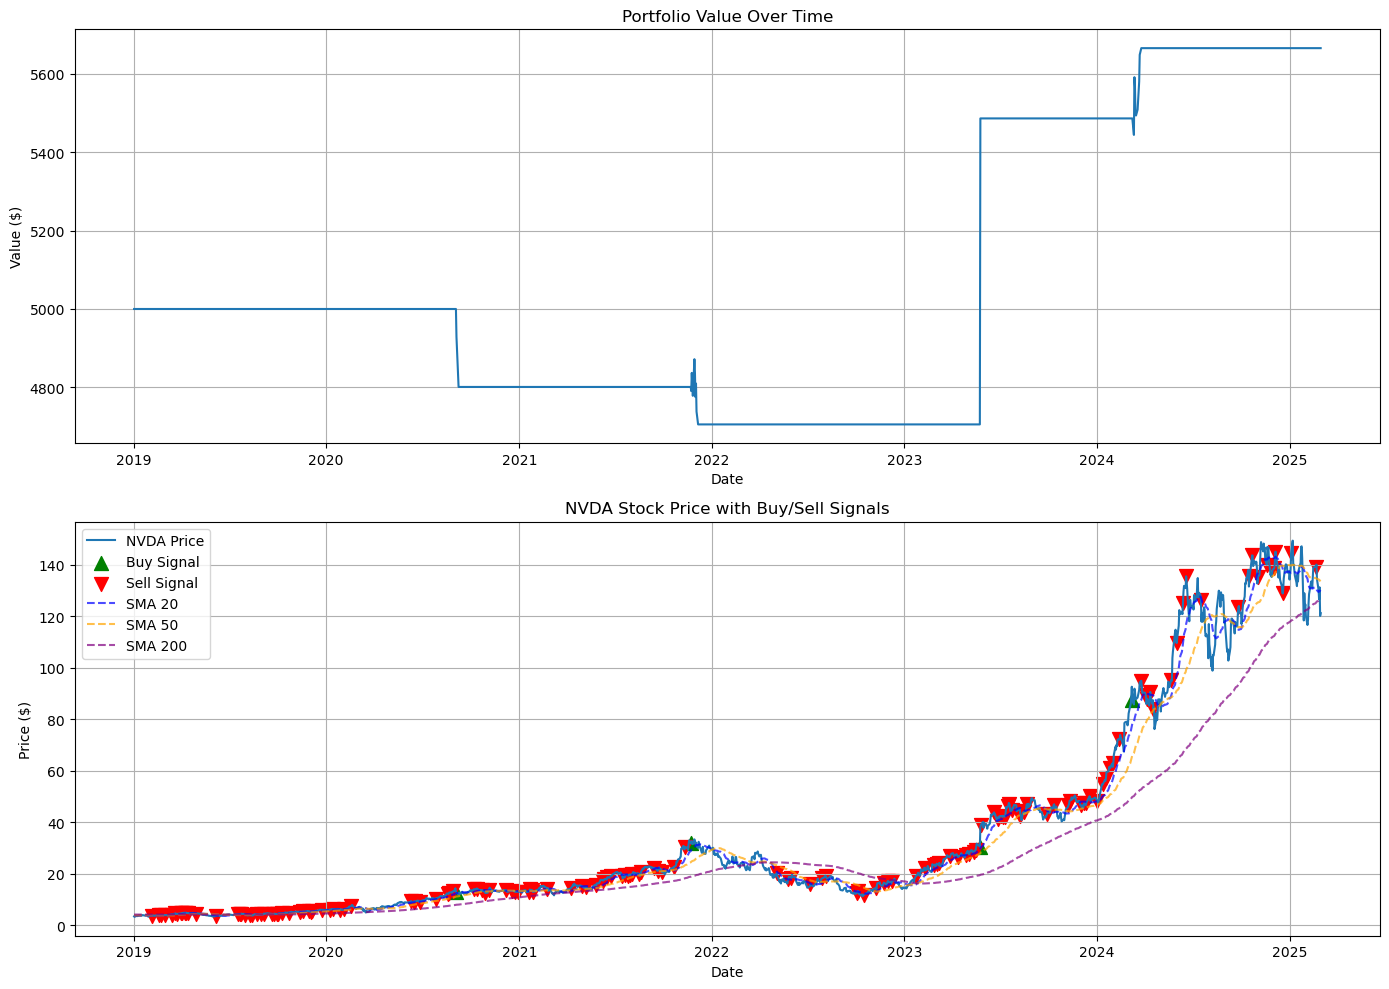

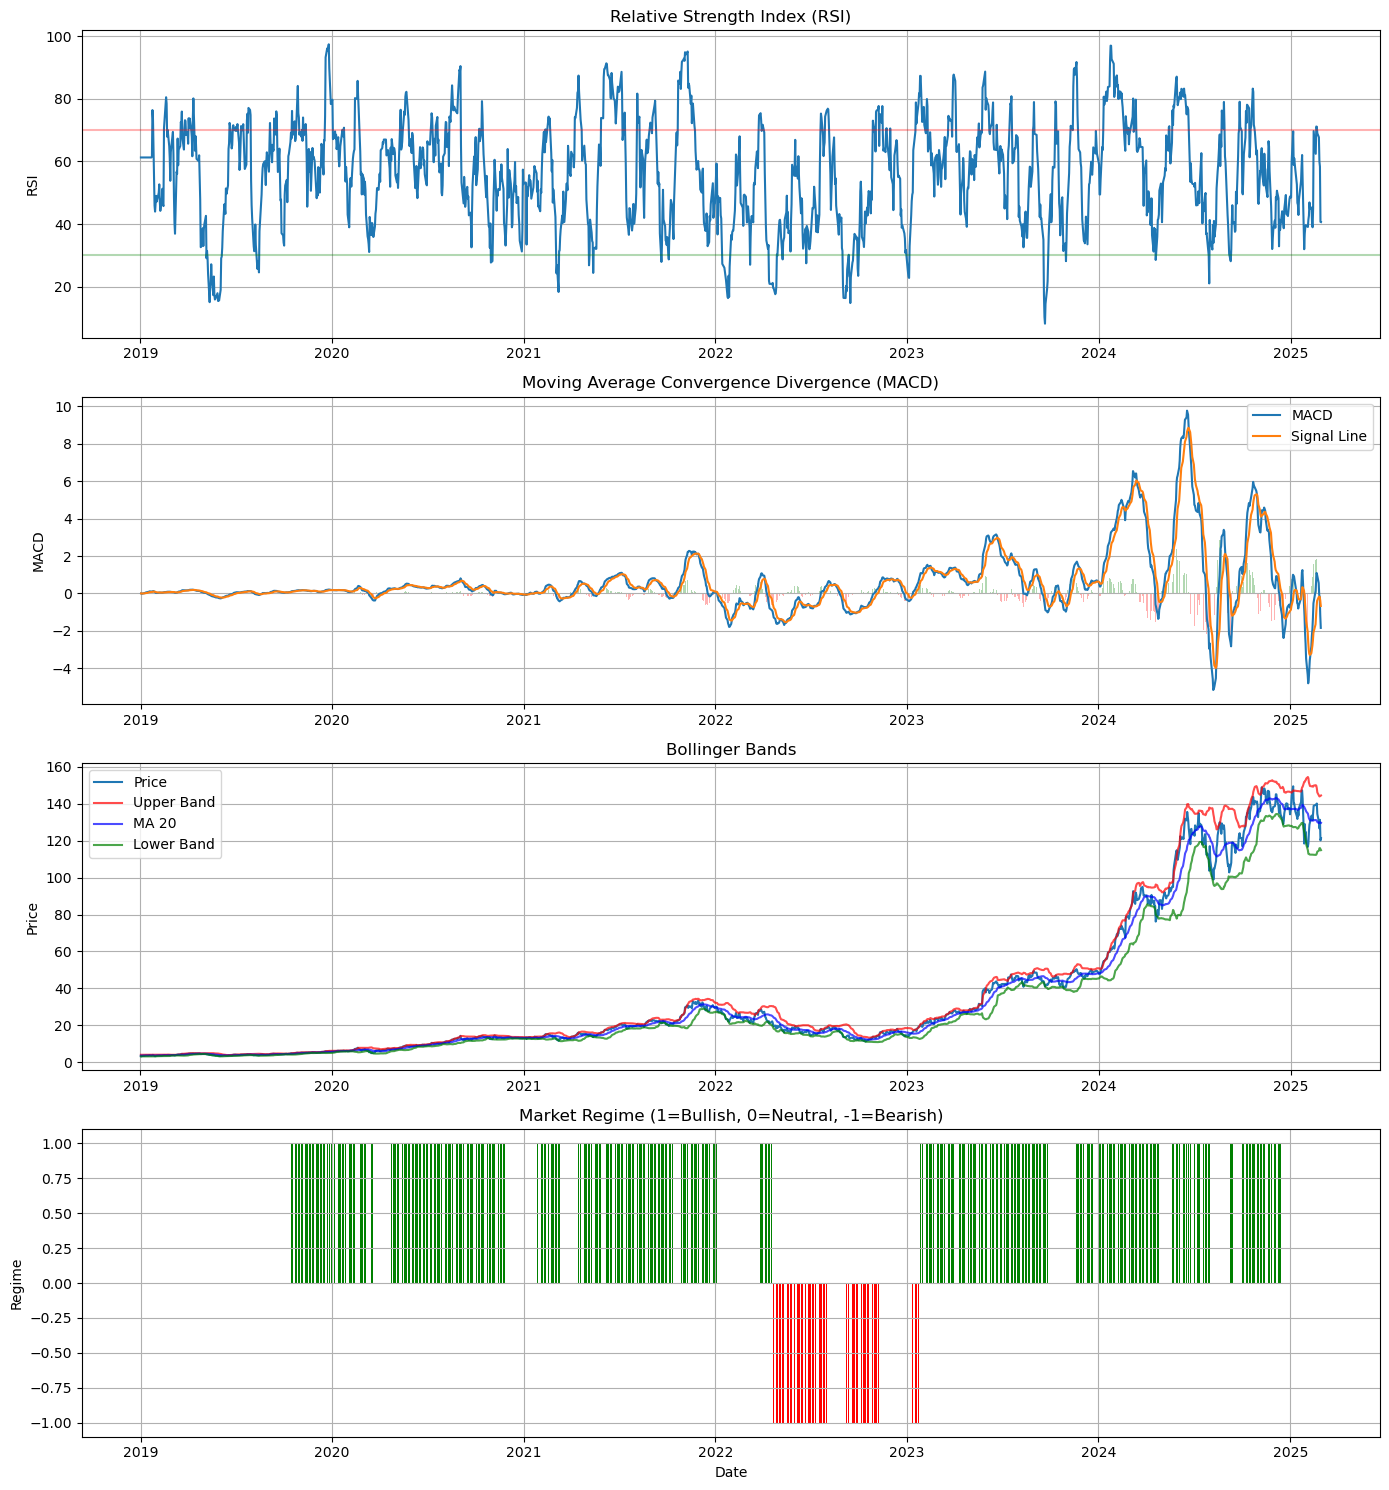

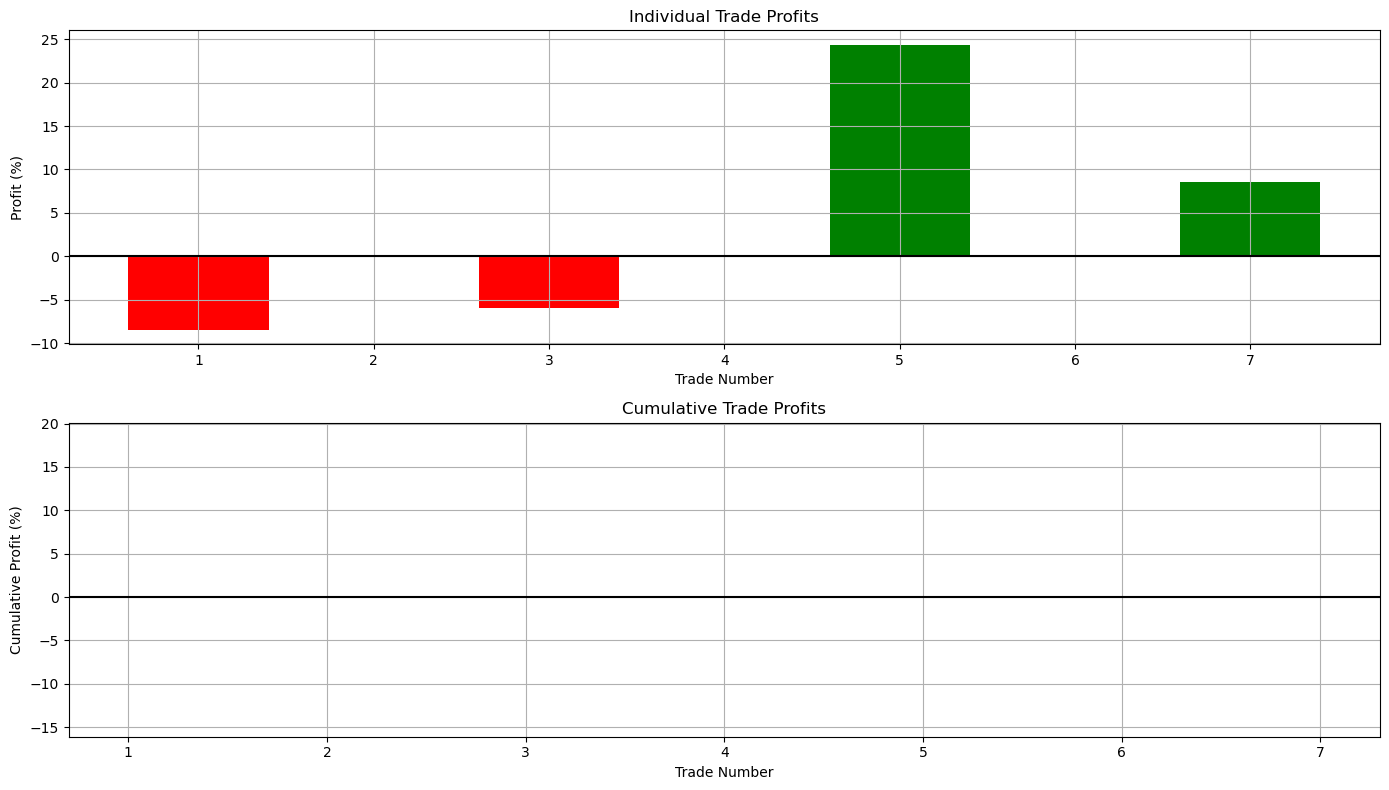

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Load the previously trained models
def load_models():
    """
    Load the previously trained XGBoost models
    """
    try:
        with open('models/model_1_balanced.pkl', 'rb') as f:
            model_1 = pickle.load(f)
        
        with open('models/model_2_conservative.pkl', 'rb') as f:
            model_2 = pickle.load(f)
        
        with open('models/model_3_aggressive.pkl', 'rb') as f:
            model_3 = pickle.load(f)
        
        print("Successfully loaded trained models")
        return [model_1, model_2, model_3]
    except Exception as e:
        print(f"Error loading models: {e}")
        return None

# Load the test dataset
def load_test_data():
  
    try:
      
        df = pd.read_excel("NVDA_test.xlsx")
        df['Date'] = pd.to_datetime(df['Date'])
        
        print(f"Loaded test data with {len(df)} rows")
        print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
        
        return df
    except Exception as e:
        print(f"Error loading test data: {e}")
        return None

# Add technical indicators (same as your original code)
def add_indicators(df):
    """
    Add technical indicators for trading strategy
    """
    # Moving Averages
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    
    # MACD
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['Signal_Line']
    
    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    # Avoid division by zero
    rs = gain / loss.replace(0, np.nan).fillna(loss.mean())
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['std_dev'] = df['Close'].rolling(window=20).std()
    df['Upper_Band'] = df['MA_20'] + (df['std_dev'] * 2)
    df['Lower_Band'] = df['MA_20'] - (df['std_dev'] * 2)
    df['BB_Width'] = (df['Upper_Band'] - df['Lower_Band']) / df['MA_20']
    df['BB_Position'] = (df['Close'] - df['Lower_Band']) / (df['Upper_Band'] - df['Lower_Band'])
    
    # Average True Range (ATR)
    df['TR'] = np.maximum(
        df['High'] - df['Low'],
        np.maximum(
            abs(df['High'] - df['Close'].shift(1)),
            abs(df['Low'] - df['Close'].shift(1))
        )
    )
    df['ATR'] = df['TR'].rolling(window=14).mean()
    df['ATR_Pct'] = df['ATR'] / df['Close']  # ATR as percentage of price
    
    # Volume-based indicators
    df['Volume_Change'] = df['Volume'].pct_change()
    df['Volume_MA_20'] = df['Volume'].rolling(window=20).mean()
    df['Relative_Volume'] = df['Volume'] / df['Volume_MA_20']
    
    # Price momentum
    df['Momentum_5'] = df['Close'] / df['Close'].shift(5) - 1
    df['Momentum_10'] = df['Close'] / df['Close'].shift(10) - 1
    df['Momentum_20'] = df['Close'] / df['Close'].shift(20) - 1
    
    # Mean reversion
    df['Dist_MA_20'] = (df['Close'] - df['MA_20']) / df['MA_20']
    df['Dist_MA_50'] = (df['Close'] - df['SMA_50']) / df['SMA_50']
    
    # Market Regime Detection
    df['Regime'] = 0  # Neutral by default
    # Bullish regime: Short-term MA > Medium-term MA > Long-term MA
    bullish = (df['SMA_20'] > df['SMA_50']) & (df['SMA_50'] > df['SMA_200'])
    df.loc[bullish, 'Regime'] = 1
    # Bearish regime: Short-term MA < Medium-term MA < Long-term MA
    bearish = (df['SMA_20'] < df['SMA_50']) & (df['SMA_50'] < df['SMA_200'])
    df.loc[bearish, 'Regime'] = -1
    
    # Fill NaN values that occur at the beginning of series
    df = df.fillna(method='bfill')
    
    return df

# Function to prepare features for the model
def prepare_features(df):
    """
    Prepare features for the machine learning model
    """
    # List of features to include in the model
    feature_columns = [
        'SMA_20', 'SMA_50', 'SMA_200',
        'MACD', 'Signal_Line', 'MACD_Hist',
        'RSI', 'MA_20', 'std_dev', 'BB_Width', 'BB_Position',
        'ATR', 'ATR_Pct', 'Volume_Change', 'Relative_Volume',
        'Momentum_5', 'Momentum_10', 'Momentum_20',
        'Dist_MA_20', 'Dist_MA_50', 'Regime'
    ]
    
    # Drop rows with NaN values (which occur at the beginning due to rolling calculations)
    df_clean = df.dropna().copy()
    
    # Extract features (X)
    X = df_clean[feature_columns]
    
    return df_clean, X

# Generate trading signals
def generate_trading_signals(df_clean, ensemble_probas):
    """
    Generate trading signals based on ensemble predictions with refined entry criteria
    """
    # Add probabilities to the dataframe
    df_clean['Ensemble_Probability'] = ensemble_probas
    
    # Initialize signal columns
    df_clean['Buy'] = 0
    df_clean['Sell'] = 0
    
    # Market regime adaptation
    for i in range(1, len(df_clean)):
        regime = df_clean['Regime'].iloc[i]
        
        # Set different thresholds based on market regime
        if regime == 1:  # Bullish regime
            buy_threshold = 0.55  # Lower buy threshold in bullish market
            sell_threshold = 0.3   # Lower sell threshold
        elif regime == -1:  # Bearish regime
            buy_threshold = 0.8   # Higher buy threshold in bearish market
            sell_threshold = 0.4   # Higher sell threshold
        else:  # Neutral regime
            buy_threshold = 0.65  # Default
            sell_threshold = 0.35  # Default
        
        prev_prob = df_clean['Ensemble_Probability'].iloc[i-1]
        curr_prob = df_clean['Ensemble_Probability'].iloc[i]
        
        # Buy signal: probability crosses above threshold
        if prev_prob < buy_threshold and curr_prob >= buy_threshold:
            df_clean.loc[df_clean.index[i], 'Buy'] = 1
        
        # Sell signal: probability crosses below threshold
        elif prev_prob > sell_threshold and curr_prob <= sell_threshold:
            df_clean.loc[df_clean.index[i], 'Sell'] = 1
    
    # IMPROVEMENT: Trend filtering - Only take buy signals in strong uptrends
    strong_uptrend = (df_clean['SMA_20'] > df_clean['SMA_50']) & (df_clean['SMA_50'] > df_clean['SMA_200'])
    df_clean.loc[~strong_uptrend, 'Buy'] = 0  # No buying except in strong uptrends
    
    # IMPROVEMENT: More selective buying criteria
    price_momentum = df_clean['Momentum_5'] > 0  # Positive short-term momentum
    volume_confirmation = df_clean['Relative_Volume'] > 1.2  # Above average volume
    bollinger_position = df_clean['BB_Position'] < 0.3  # Not overbought in Bollinger terms
    
    # Require at least 2 of these 3 additional confirmations
    confirmation_count = price_momentum.astype(int) + volume_confirmation.astype(int) + bollinger_position.astype(int)
    df_clean.loc[(df_clean['Buy'] == 1) & (confirmation_count < 2), 'Buy'] = 0
    
    # Signal confirmation with technical indicators
    rsi_oversold = df_clean['RSI'] < 35  # Slightly relaxed from 30
    macd_positive = df_clean['MACD'] > df_clean['Signal_Line']
    price_above_sma = df_clean['Close'] > df_clean['SMA_50']
    
    # Only keep buy signals that have at least 2 of the 3 confirmation indicators
    tech_confirmation_count = rsi_oversold.astype(int) + macd_positive.astype(int) + price_above_sma.astype(int)
    df_clean.loc[(df_clean['Buy'] == 1) & (tech_confirmation_count < 2), 'Buy'] = 0
    
    return df_clean

# Backtest with profit targets and improved risk management
def backtest_strategy(df, initial_budget=10000, fixed_deposit_pct=0.5, annual_interest_rate=0.04):
    """
    Backtest the trading strategy with improved risk management, profit targets and position sizing
    """
    # Setup initial allocation
    trading_capital = initial_budget * (1 - fixed_deposit_pct)
    fixed_deposit = initial_budget * fixed_deposit_pct
    
    # Calculate fixed deposit growth
    start_date = df['Date'].min()
    end_date = df['Date'].max()
    days_difference = max(1, (end_date - start_date).days)
    years_passed = days_difference / 365.25
    fixed_deposit_end = fixed_deposit * ((1 + annual_interest_rate) ** years_passed)
    
    # Initialize trading variables
    cash = trading_capital
    shares = 0
    trades = []
    portfolio_values = []
    entry_price = 0  # Track entry price for stop loss
    
    # IMPROVEMENT: Enhanced risk management parameters
    max_loss_pct = 0.05  # 5% stop loss
    take_profit_pct = 0.12  # 12% profit target (NEW)
    trailing_stop_pct = 0.08  # Reduced from 10% to 8% (tighter)
    trailing_stop_activation = 0.10  # Reduced from 15% to 10% (activate earlier)
    max_position_pct = 0.90  # Slightly reduced from 95% to 90%
    
    # Track winning and losing trades for proper profit factor calculation
    winning_trade_profits = 0
    losing_trade_losses = 0
    
    # Loop through the data
    for i in range(len(df)):
        current_date = df['Date'].iloc[i]
        price = df['Close'].iloc[i]
        buy_signal = df['Buy'].iloc[i]
        sell_signal = df['Sell'].iloc[i]
        
        # Track portfolio value before any trades
        portfolio_value = cash + (shares * price)
        portfolio_values.append({
            'Date': current_date,
            'Cash': cash,
            'Shares': shares,
            'Portfolio_Value': portfolio_value
        })
        
        # Apply exit strategies if we have shares
        if shares > 0:
            # Calculate current profit percentage
            current_profit_pct = (price / entry_price) - 1
            
            # IMPROVEMENT: Check if profit target is reached
            if price >= entry_price * (1 + take_profit_pct):
                # Take profit triggered
                proceeds = shares * price
                
                trades.append({
                    'Date': current_date,
                    'Action': 'TAKE PROFIT',
                    'Price': price,
                    'Shares': shares,
                    'Value': proceeds,
                    'Cash': cash + proceeds,
                    'Profit_Pct': current_profit_pct * 100
                })
                
                # Update winning trade tracking
                winning_trade_profits += current_profit_pct * proceeds
                
                # Update portfolio
                cash += proceeds
                shares = 0
                continue  # Skip to next iteration
            
            # Check if stop loss is triggered
            if price <= entry_price * (1 - max_loss_pct):
                # Stop loss triggered
                proceeds = shares * price
                
                trades.append({
                    'Date': current_date,
                    'Action': 'STOP LOSS',
                    'Price': price,
                    'Shares': shares,
                    'Value': proceeds,
                    'Cash': cash + proceeds,
                    'Profit_Pct': current_profit_pct * 100
                })
                
                # Update losing trade tracking
                losing_trade_losses += abs(current_profit_pct) * proceeds
                
                # Update portfolio
                cash += proceeds
                shares = 0
                continue  # Skip to next iteration
            
            # IMPROVEMENT: Tighter trailing stop that activates earlier
            if current_profit_pct >= trailing_stop_activation:
                # Calculate trailing stop price
                max_price_seen = max(entry_price * (1 + current_profit_pct), df['High'].iloc[i])
                trailing_stop_price = max_price_seen * (1 - trailing_stop_pct)
                
                if price <= trailing_stop_price:
                    # Trailing stop triggered
                    proceeds = shares * price
                    
                    trades.append({
                        'Date': current_date,
                        'Action': 'TRAILING STOP',
                        'Price': price,
                        'Shares': shares,
                        'Value': proceeds,
                        'Cash': cash + proceeds,
                        'Profit_Pct': current_profit_pct * 100
                    })
                    
                    # Update trade profit tracking based on whether it's a win or loss
                    if current_profit_pct > 0:
                        winning_trade_profits += current_profit_pct * proceeds
                    else:
                        losing_trade_losses += abs(current_profit_pct) * proceeds
                    
                    # Update portfolio
                    cash += proceeds
                    shares = 0
                    continue  # Skip to next iteration
        
        # Handle buy signal
        if buy_signal == 1 and cash > price and shares == 0:
            # Position sizing based on volatility
            volatility = df['ATR_Pct'].iloc[i]
            if np.isnan(volatility) or volatility <= 0:
                volatility = 0.02  # Default if not available
                
            # Adjust position size inversely with volatility (higher volatility = smaller position)
            position_pct = min(max_position_pct, 0.02 / volatility)
            position_value = cash * position_pct
            
            # Calculate how many shares to buy
            shares_to_buy = int(position_value // price)
            
            if shares_to_buy > 0:  # Only buy if we can afford at least one share
                cost = shares_to_buy * price
                
                # Update portfolio
                shares = shares_to_buy
                cash -= cost
                entry_price = price  # Track entry price for stop loss
                
                trades.append({
                    'Date': current_date,
                    'Action': 'BUY',
                    'Price': price,
                    'Shares': shares,
                    'Value': cost,
                    'Cash': cash,
                    'Position_Pct': position_pct * 100
                })
        
        # Handle sell signal
        elif sell_signal == 1 and shares > 0:
            # Calculate profit percentage
            profit_pct = (price / entry_price) - 1
            
            # Sell all shares
            proceeds = shares * price
            
            trades.append({
                'Date': current_date,
                'Action': 'SELL',
                'Price': price,
                'Shares': shares,
                'Value': proceeds,
                'Cash': cash + proceeds,
                'Profit_Pct': profit_pct * 100
            })
            
            # Update trade profit tracking based on whether it's a win or loss
            if profit_pct > 0:
                winning_trade_profits += profit_pct * proceeds
            else:
                losing_trade_losses += abs(profit_pct) * proceeds
            
            # Update portfolio
            cash += proceeds
            shares = 0
    
    # Liquidate any remaining positions at the end
    if shares > 0:
        final_price = df['Close'].iloc[-1]
        proceeds = shares * final_price
        profit_pct = (final_price / entry_price) - 1
        
        trades.append({
            'Date': df['Date'].iloc[-1],
            'Action': 'FINAL SELL',
            'Price': final_price,
            'Shares': shares,
            'Value': proceeds,
            'Cash': cash + proceeds,
            'Profit_Pct': profit_pct * 100
        })
        
        # Update trade profit tracking based on whether it's a win or loss
        if profit_pct > 0:
            winning_trade_profits += profit_pct * proceeds
        else:
            losing_trade_losses += abs(profit_pct) * proceeds
        
        cash += proceeds
        shares = 0
    
    # Calculate final values
    final_trading_value = cash
    final_total_value = final_trading_value + fixed_deposit_end
    
    # Calculate returns
    total_return = (final_total_value / initial_budget - 1) * 100
    annual_return = ((final_total_value / initial_budget) ** (1 / years_passed) - 1) * 100
    
    # Calculate trade statistics
    if len(trades) > 0:
        trade_df = pd.DataFrame(trades)
        
        # Calculate winning and losing trades
        if 'Profit_Pct' in trade_df.columns:
            winning_trades = trade_df[trade_df['Profit_Pct'] > 0]
            losing_trades = trade_df[trade_df['Profit_Pct'] <= 0]
            
            win_rate = len(winning_trades) / len(trade_df) * 100 if len(trade_df) > 0 else 0
            avg_win = winning_trades['Profit_Pct'].mean() if len(winning_trades) > 0 else 0
            avg_loss = losing_trades['Profit_Pct'].mean() if len(losing_trades) > 0 else 0
            
            # Fixed profit factor calculation
            profit_factor = winning_trade_profits / losing_trade_losses if losing_trade_losses > 0 else float('inf')
        else:
            win_rate = 0
            avg_win = 0
            avg_loss = 0
            profit_factor = 0
    else:
        win_rate = 0
        avg_win = 0
        avg_loss = 0
        profit_factor = 0
    
    # Create results dictionary
    results = {
        'Initial_Budget': initial_budget,
        'Trading_Capital': trading_capital,
        'Fixed_Deposit': fixed_deposit,
        'Fixed_Deposit_End': fixed_deposit_end,
        'Final_Trading_Value': final_trading_value,
        'Final_Total_Value': final_total_value,
        'Total_Return_Pct': total_return,
        'Annual_Return_Pct': annual_return,
        'Number_of_Trades': len(trades),
        'Win_Rate': win_rate,
        'Avg_Win_Pct': avg_win,
        'Avg_Loss_Pct': avg_loss,
        'Profit_Factor': profit_factor,
        'Trades': trades,
        'Portfolio_Values': portfolio_values
    }
    
    return results

# Plot performance over time
def plot_performance(results, test_data):
    """
    Plot portfolio value over time
    """
    # Extract portfolio values for plotting
    portfolio_values = results['Portfolio_Values']
    dates = [pv['Date'] for pv in portfolio_values]
    portfolio_values = [pv['Portfolio_Value'] for pv in portfolio_values]
    
    # Plot performance
    plt.figure(figsize=(14, 10))
    
    # Plot 1: Portfolio Value
    plt.subplot(2, 1, 1)
    plt.plot(dates, portfolio_values)
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.grid(True)
    
    # Plot 2: Stock Price with Buy/Sell Signals
    plt.subplot(2, 1, 2)
    plt.plot(test_data['Date'], test_data['Close'], label='NVDA Price')
    
    # Plot buy signals
    buy_signals = test_data[test_data['Buy'] == 1]
    if not buy_signals.empty:
        plt.scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', s=100, label='Buy Signal')
    
    # Plot sell signals
    sell_signals = test_data[test_data['Sell'] == 1]
    if not sell_signals.empty:
        plt.scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', s=100, label='Sell Signal')
    
    # Add moving averages to the chart
    plt.plot(test_data['Date'], test_data['SMA_20'], '--', color='blue', alpha=0.7, label='SMA 20')
    plt.plot(test_data['Date'], test_data['SMA_50'], '--', color='orange', alpha=0.7, label='SMA 50')
    plt.plot(test_data['Date'], test_data['SMA_200'], '--', color='purple', alpha=0.7, label='SMA 200')
    
    plt.title('NVDA Stock Price with Buy/Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('NVDA_test_performance.png')
    plt.show()
    
    # Plot trades and technical indicators
    plt.figure(figsize=(14, 15))
    
    # Plot 1: RSI
    plt.subplot(4, 1, 1)
    plt.plot(test_data['Date'], test_data['RSI'])
    plt.axhline(y=70, color='r', linestyle='-', alpha=0.3)
    plt.axhline(y=30, color='g', linestyle='-', alpha=0.3)
    plt.title('Relative Strength Index (RSI)')
    plt.ylabel('RSI')
    plt.grid(True)
    
    # Plot 2: MACD
    plt.subplot(4, 1, 2)
    plt.plot(test_data['Date'], test_data['MACD'], label='MACD')
    plt.plot(test_data['Date'], test_data['Signal_Line'], label='Signal Line')
    plt.bar(test_data['Date'], test_data['MACD_Hist'], color=np.where(test_data['MACD_Hist'] >= 0, 'green', 'red'), alpha=0.3)
    plt.title('Moving Average Convergence Divergence (MACD)')
    plt.ylabel('MACD')
    plt.legend()
    plt.grid(True)
    
    # Plot 3: Bollinger Bands
    plt.subplot(4, 1, 3)
    plt.plot(test_data['Date'], test_data['Close'], label='Price')
    plt.plot(test_data['Date'], test_data['Upper_Band'], label='Upper Band', color='red', alpha=0.7)
    plt.plot(test_data['Date'], test_data['MA_20'], label='MA 20', color='blue', alpha=0.7)
    plt.plot(test_data['Date'], test_data['Lower_Band'], label='Lower Band', color='green', alpha=0.7)
    plt.title('Bollinger Bands')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    
    # Plot 4: Market Regime
    plt.subplot(4, 1, 4)
    plt.bar(test_data['Date'], test_data['Regime'], color=np.where(test_data['Regime'] > 0, 'green', np.where(test_data['Regime'] < 0, 'red', 'gray')))
    plt.title('Market Regime (1=Bullish, 0=Neutral, -1=Bearish)')
    plt.xlabel('Date')
    plt.ylabel('Regime')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('NVDA_test_indicators.png')
    plt.show()
    
    # If there are trades, plot the trade results
    if results['Number_of_Trades'] > 0:
        # Convert trades to DataFrame for easier analysis
        trades_df = pd.DataFrame(results['Trades'])
        
        # Plot trade results if profit data exists
        if 'Profit_Pct' in trades_df.columns:
            plt.figure(figsize=(14, 8))
            
            # Plot individual trade profits
            plt.subplot(2, 1, 1)
            colors = ['green' if profit > 0 else 'red' for profit in trades_df['Profit_Pct']]
            plt.bar(range(len(trades_df)), trades_df['Profit_Pct'], color=colors)
            plt.axhline(y=0, color='black', linestyle='-')
            plt.title('Individual Trade Profits')
            plt.xlabel('Trade Number')
            plt.ylabel('Profit (%)')
            plt.grid(True)
            
            # Plot cumulative trade profits
            plt.subplot(2, 1, 2)
            cumulative_profits = trades_df['Profit_Pct'].cumsum()
            plt.plot(range(len(trades_df)), cumulative_profits)
            plt.axhline(y=0, color='black', linestyle='-')
            plt.title('Cumulative Trade Profits')
            plt.xlabel('Trade Number')
            plt.ylabel('Cumulative Profit (%)')
            plt.grid(True)
            
            plt.tight_layout()
            plt.savefig('NVDA_test_trade_profits.png')
            plt.show()

# Main function for testing
def test_model():
    # Step 1: Load the test data
    print("Loading test data...")
    test_data = load_test_data()
    if test_data is None:
        print("Failed to load test data. Exiting.")
        return
    
    # Step 2: Load trained models
    print("Loading previously trained models...")
    models = load_models()
    if models is None:
        print("Failed to load models. Exiting.")
        return
    
    # Step 3: Add technical indicators to test data
    print("Adding technical indicators to test data...")
    test_data = add_indicators(test_data)
    
    # Step 4: Prepare features for the model
    print("Preparing features for prediction...")
    test_clean, X_test = prepare_features(test_data)
    
    # Step 5: Predict with ensemble models
    print("Making predictions with ensemble models...")
    probas = []
    for i, model in enumerate(models):
        # Get probabilities of positive class
        proba = model.predict_proba(X_test)[:, 1]
        probas.append(proba)
        print(f"Model {i+1} predictions generated")
    
    # Calculate ensemble probabilities (average of all models)
    ensemble_probas = np.mean(probas, axis=0)
    
    # Step 6: Generate trading signals
    print("Generating trading signals...")
    test_clean = generate_trading_signals(test_clean, ensemble_probas)
    
    # Count signals to verify they exist
    buy_signals_count = test_clean['Buy'].sum()
    sell_signals_count = test_clean['Sell'].sum()
    print(f"Generated {buy_signals_count} buy signals and {sell_signals_count} sell signals in test data")
    
    # Step 7: Backtest the strategy
    print("Backtesting strategy on test data...")
    results = backtest_strategy(test_clean, initial_budget=10000, fixed_deposit_pct=0.5)
    
    # Print results
    print("\n===== TRADING STRATEGY RESULTS ON TEST DATA (2019-Feb 2025) =====")
    print(f"Initial Budget: ${results['Initial_Budget']:.2f}")
    print(f"Trading Allocation: ${results['Trading_Capital']:.2f} ({results['Trading_Capital']/results['Initial_Budget']*100:.1f}%)")
    print(f"Fixed Deposit: ${results['Fixed_Deposit']:.2f} ({results['Fixed_Deposit']/results['Initial_Budget']*100:.1f}%)")
    print(f"Final Trading Value: ${results['Final_Trading_Value']:.2f}")
    print(f"Final Fixed Deposit Value: ${results['Fixed_Deposit_End']:.2f}")
    print(f"Final Total Value: ${results['Final_Total_Value']:.2f}")
    print(f"Total Return: {results['Total_Return_Pct']:.2f}%")
    print(f"Annual Return: {results['Annual_Return_Pct']:.2f}%")
    print(f"Number of Trades: {results['Number_of_Trades']}")
    print(f"Win Rate: {results['Win_Rate']:.1f}%")
    print(f"Average Win: {results['Avg_Win_Pct']:.2f}%")
    print(f"Average Loss: {results['Avg_Loss_Pct']:.2f}%")
    print(f"Profit Factor: {results['Profit_Factor']:.2f}")
    
    # Print the first few trades
    if results['Number_of_Trades'] > 0:
        print("\n===== SAMPLE TRADES =====")
        for i in range(min(5, results['Number_of_Trades'])):
            trade = results['Trades'][i]
            print(f"Date: {trade['Date'].strftime('%Y-%m-%d')}, Action: {trade['Action']}, Price: ${trade['Price']:.2f}, Shares: {trade['Shares']}, Value: ${trade['Value']:.2f}")
            if 'Profit_Pct' in trade:
                print(f"  Profit: {trade['Profit_Pct']:.2f}%")
    
    # Save final result to CSV
    print("\nSaving results to 'NVDA_testing_results.csv'...")
    # Format exactly as required with Buy and Sell columns
    final_output = test_clean[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Buy', 'Sell']].copy()
    final_output.to_csv('NVDA_testing_results.csv', index=False)
    
    # Show sample of the output
    print("\n===== SAMPLE OUTPUT FORMAT =====")
    print(final_output.head(10))
    
    # Plot performance and analysis charts
    print("\nGenerating performance charts...")
    plot_performance(results, test_clean)
    
    return results

# Run the test
if __name__ == "__main__":
    test_model()